Initialization

In [11]:
%load_ext autoreload
%autoreload 2
import unittest
from propensity_with_density import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import math
from true_overlap_scipy import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Seed: 0


Parameters

In [12]:
epsilon = 0.05
N_samples = 500
# nr. of randomizations of simulated data
trials = 15

# nr. of changes
# 1 region:
# mean2_array = [2.5, 1, 0.65, 0.5, 0.43, 0.39]
# sd2_array = [1, 1, 0.5, 0.33, 0.25, 0.2]
# sd1_array = sd2_array

# 2 regions:
mean2_array = [3.1, 1.1, 0.59, 0.38, 0.3, 0.28]
sd1_array = [2.0, 1.0, 2.0/3, 0.5, 0.4, 2.0/6]
sd2_array = [1.4, 0.7, 1.4/3, 1.4/4, 1.4/5, 1.4/6]

dims = len(mean2_array)
dim_array = range(1, dims+1)
runs = len(dim_array)

Trials

In [13]:
def sample_normal(mean1, mean2, sd1, sd2, n, m):
    x1 = np.random.normal(mean1, sd1, (n, m))
    x2 = np.random.normal(mean2, sd2, (n, m))

    return x1, x2

def sample_normal_2_means(mean1, mean2, sd1, sd2, n, m):
    x1 = np.random.normal(mean1, sd1, (n, m))

    bool_array = np.random.choice([0, 1], size=(n,1))
    region1 = np.random.normal(-mean2, sd2, (n, m))
    region2 = np.random.normal(mean2, sd2, (n, m))
    bool_matrix = np.repeat(bool_array, m, axis=1)
    x2 = region1 * bool_matrix + region2 * (1 - bool_matrix)
    return x1, x2

def sample_uniform_2_means(l1, r1, mean2, sd2, n, m):
    x1 = np.random.uniform(l1, r1, (n, m))

    bool_array = np.random.choice([0, 1], size=(n,1))
    region1 = np.random.normal(-mean2, sd2, (n, m))
    region2 = np.random.normal(mean2, sd2, (n, m))
    bool_matrix = np.repeat(bool_array, m, axis=1)
    x2 = region1 * bool_matrix + region2 * (1 - bool_matrix)
    return x1, x2

# Freedman-Diaconis rule
def bin_size(x1, x2, dim):
    x = np.concatenate([x1, x2]).reshape(-1, dim)
    n = 1000
    minimum = x.min(axis=0)
    maximum = x.max(axis=0)
    q3, q1 = np.percentile(x, [75 ,25],axis=0)
    iqr = q3 - q1
    h = 2.0 * iqr * math.pow(n, -1.0/3.0)
    bins = (maximum - minimum)/h
    return int(np.average(bins))

classifier_names = ["lr", "dtc", "rfc"]
N_classifiers = len(classifier_names)
classifier_parameters = [{"C": 10}, {"max_depth":5, "min_samples_leaf":10}, {}]
classifier_results = np.empty((N_classifiers, runs))
classifier_variance = np.empty((N_classifiers, runs))

for k in range(N_classifiers):

    results = np.empty(runs)
    variance = np.empty(runs)
    classifier = classifier_names[k]
    parameters = classifier_parameters[k]

    for i in range(runs):
        print("Round: " + str(i))

        dim = dim_array[i]
        mean2 = mean2_array[i]
        sd1 = sd1_array[i]
        sd2 = sd2_array[i]

        iou_array = np.empty(trials)

        for j in range(trials):
            # Set new seed
            seed = j
            np.random.seed(seed)

            # Generate simulated data with new seed
            # 1 region of overlap:
            # x1, x2 = sample_normal(0, mean2, sd1, sd2, N_samples, dim)
            # 2 regions of overlap instead:
            x1, x2 = sample_normal_2_means(0, mean2, sd1, sd2, N_samples, dim)

            X = np.concatenate([x1, x2]).reshape(-1, dim)
            y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

            mean1_gaussian = np.zeros(dim)
            mean2_gaussian = np.ones(dim) * mean2
            cov1 = np.diag(np.ones(dim) * sd1)
            cov2 = np.diag(np.ones(dim) * sd2)
            # which true overlap depends on which scenario
            # true_overlap_labels = check_true_overlap(mean1_gaussian, mean2_gaussian, cov1, cov2, x1, x2, epsilon, dim).astype(int)
            true_overlap_labels = check_true_overlap_2_regions(mean1_gaussian, mean2_gaussian, cov1, cov2, x1, x2, epsilon, dim).astype(int)

            # Setup Propensity score model
            propensity = PropensityDensity(classifier, epsilon)
            propensity.tune_hyperparameters(classifier, X, y)

            iou = propensity.score(X, true_overlap_labels, score_type="iou")
            iou_array[j] = (iou)

        results[i] = np.average(iou_array)
        diff = iou_array - results[i]
        variance[i] = (diff * diff).sum() / trials
    classifier_results[k] = results
    classifier_variance[k] = variance

lr = classifier_results[0]
dtc = classifier_results[1]
rfc = classifier_results[2]
lr_var = classifier_variance[0]
dtc_var = classifier_variance[1]
rfc_var = classifier_variance[2]

Round: 0
Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 0
Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 0
Round: 1
Round: 2
Round: 3
Round: 4
Round: 5


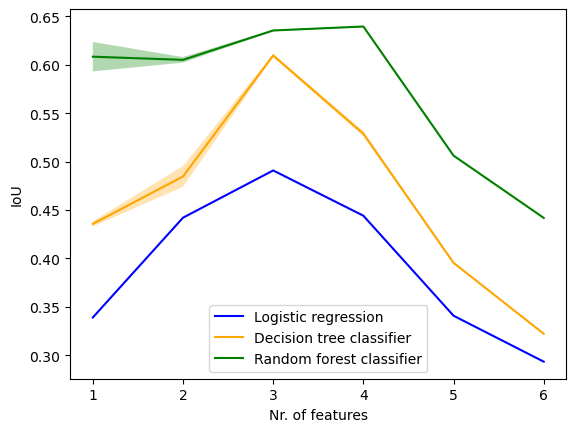

In [14]:
plt.figure(1)
plt.xticks(dim_array)
plt.plot(dim_array, lr, label="Logistic regression", color="blue")
plt.plot(dim_array, dtc, label="Decision tree classifier", color="orange")
plt.plot(dim_array, rfc, label="Random forest classifier", color="green")
plt.fill_between(dim_array, lr-lr_var, lr+lr_var ,alpha=0.3, facecolor="blue")
plt.fill_between(dim_array, dtc-dtc_var, dtc+dtc_var ,alpha=0.3, facecolor="orange")
plt.fill_between(dim_array, rfc-rfc_var, rfc+rfc_var ,alpha=0.3, facecolor="green")
plt.xlabel("Nr. of features")
plt.ylabel("IoU")
plt.legend()
plt.show()

In [15]:
# iou's
print(lr)
print(dtc)
print(rfc)
# variance
print(lr_var)
print(dtc_var)
print(rfc_var)

[0.33907223 0.44210348 0.49089057 0.4441561  0.34087103 0.29344021]
[0.43567786 0.48470879 0.60963352 0.52879495 0.39548484 0.32226902]
[0.60836466 0.6050842  0.63543329 0.63952403 0.50621435 0.44191144]
[0.00031764 0.0004413  0.00055464 0.0002458  0.0003134  0.00026447]
[0.00266006 0.0107975  0.0017303  0.00267581 0.00083548 0.00061121]
[0.01519633 0.00288078 0.00080278 0.00060734 0.00056683 0.00046797]
